In [1]:
%matplotlib inline

import PIL
import mss
import pyautogui 
import time  
import numpy  as np  
import matplotlib
from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import load_model
import os
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from IPython.display import clear_output

pyautogui.PAUSE = 0.01

SHOW_TIME = False
SHOW_DATA = True
SHOW_PLOT = True

Using TensorFlow backend.


In [2]:
def print_time(*time_data):
    if SHOW_TIME:
        print(time_data)
    
def print_data(*var_data):
    if SHOW_DATA:
        print(var_data)
    

In [3]:

restart_coords = (420, 370)
    
def restart():
    #pyautogui.click(restart_coords)
    pyautogui.keyDown('space')
    pyautogui.keyUp('space')    


def jump(should_jump):
    if should_jump:
        pyautogui.keyDown('space')
        pyautogui.keyUp('space')
        

def check_val_and_act(val):
    if val == 1: 
        jump(True)
        return 1
    else:
        jump(False)
        return 0

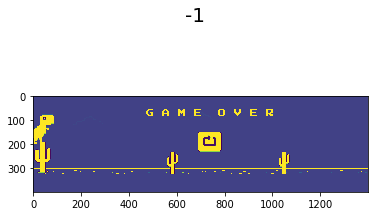

In [4]:
def display_image(image, title):
    if SHOW_PLOT:
        plt.figure().suptitle(title, fontsize=20)
        plt.imshow(image)
        plt.show()
    
def capture_image():
    image = mss.mss().grab({"top":350, "left":50, "width":700, "height":200})
    #image = mss.mss().grab({"top":560, "left":50, "width":1000, "height":250})
    return PIL.Image.frombytes("RGB", image.size, image.bgra, "raw", "BGRX")

def convert_to_greyscale_image(color_image):
    THRESHOLD_VALUE = 125
    image = color_image.convert("L")
    orig_image = np.asarray(image)
    image = image.resize((300, 300), PIL.Image.ANTIALIAS)
    img_data = np.asarray(image)
    greyscale_image = (img_data > THRESHOLD_VALUE) * 1.0
    return greyscale_image, orig_image
    

def get_state_image():
    
    image = capture_image()
    
    greyscale_image, orig_image = convert_to_greyscale_image(image)
    
    return np.asarray(greyscale_image), orig_image
    
grey_image, full_image = get_state_image()
display_image(full_image, -1)



In [5]:
def build_model():
    cnn_model = Sequential()
    
    cnn_model.add(Conv2D(9, (21, 21), strides=(7, 7), padding='valid',input_shape=(300, 300, 1), activation='relu',
                     kernel_initializer='random_uniform'))  #20*40*4
    cnn_model.add(Conv2D(13, (11, 11), strides=(3, 3), padding='same', activation='relu', kernel_initializer='random_uniform'))
    cnn_model.add(Conv2D(25, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer='random_uniform'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
    cnn_model.add(Conv2D(39, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='random_uniform'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(512, activation='relu', kernel_initializer='random_uniform'))
    cnn_model.add(Dense(32, activation='relu', kernel_initializer='random_uniform'))
    cnn_model.add(Dense(2, activation='relu', kernel_initializer='random_uniform'))
    cnn_model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    if not os.path.isfile('my_dino.h5'):     
        cnn_model.save_weights('my_dino.h5')
    else:
        cnn_model.load_weights('my_dino.h5')
    return cnn_model


In [6]:
model = build_model()

t0 = time.time()
input_area, original_image = get_state_image()
input_area_conv = input_area[np.newaxis, ..., np.newaxis]
output_arr = model.predict(input_area_conv)[0]
print_data('Prediction output', output_arr)
t1 = time.time()
print_time('Prediction time', t1-t0)

# model.save('my_dino.h5')
    



('Prediction output', array([0.05613663, 0.05547776], dtype=float32))


In [7]:
def calc_rewards(action_data):
    immediate_reward = [0.1] * len(action_data)
    immediate_reward[-1] = -1
    print_data('immediate_reward',immediate_reward)
    total_reward = np.zeros(len(immediate_reward), dtype = float)
    for i in range(len(immediate_reward)):
        multiplier = 1
        for j in range (i, i+10):
            if j<len(immediate_reward):
                total_reward[i] += (immediate_reward[j] * multiplier)
                multiplier = multiplier * 0.9
    # print_data('total_reward final:',total_reward)
    
    return total_reward

In [8]:
def update_output(output_data, action_data, rewards):
    for i in range(len(output_data)):
        output_data[i][action_data[i]] = rewards[i]
    return  output_data

 
    


def train_data(input_data, output_data, action_data):
    print_data('Training output:', np.asarray(output_data).shape)
    #del input_data[-10:]
    #del output_data[-10:]
    #del action_data[-10:]
    input_data = np.asarray(input_data)
    output_data = np.asarray(output_data)
    rewards = calc_rewards(action_data)
    output_data = update_output(output_data, action_data, rewards)
    print_data('action_data:', action_data)
    print_data('rewards:', rewards)
    print_data('train_data->input_data:', np.asarray(input_data).shape)
    print_data('train_data->output_data:', np.asarray(output_data).shape)
    print_data('train_data->action_data:',np.asarray(action_data).shape)
    print_data('train_data->rewards:',np.asarray(rewards).shape)
    for i in range(np.asarray(input_data).shape[0]):
        display_image(np.asarray(input_data[i]).reshape(300,300), i)
    print_data('len output_data:', len(output_data))
    #for i in range(len(output_data)):
        #print_data('rewards[i]:',rewards[i])
        #output_data[i][0][0][action_data] = rewards[i]
    model.train_on_batch(np.asarray(input_data), np.asarray(output_data))
    model.save_weights('my_dino.h5', overwrite=True)
        

('input_area_conv shape:', (1, 300, 300, 1))
('Prdctn output', 0, ': ', array([[0.09249146, 0.60695755]], dtype=float32))
('train_x_shape', (1, 300, 300, 1))
('train_y_shape', (1, 2))
('input_area_conv shape:', (1, 300, 300, 1))
('Prdctn output', 1, ': ', array([[0.09913746, 0.6642828 ]], dtype=float32))
('train_x_shape', (2, 300, 300, 1))
('train_y_shape', (2, 2))
('input_area_conv shape:', (1, 300, 300, 1))
('Prdctn output', 2, ': ', array([[0.11361106, 0.6468769 ]], dtype=float32))
('train_x_shape', (3, 300, 300, 1))
('train_y_shape', (3, 2))
('input_area_conv shape:', (1, 300, 300, 1))
('Prdctn output', 3, ': ', array([[0.10622714, 0.5596656 ]], dtype=float32))
('train_x_shape', (4, 300, 300, 1))
('train_y_shape', (4, 2))
('input_area_conv shape:', (1, 300, 300, 1))
('Prdctn output', 4, ': ', array([[0.10074212, 0.5009253 ]], dtype=float32))
('train_x_shape', (5, 300, 300, 1))
('train_y_shape', (5, 2))
('input_area_conv shape:', (1, 300, 300, 1))
('Prdctn output', 5, ': ', array([[

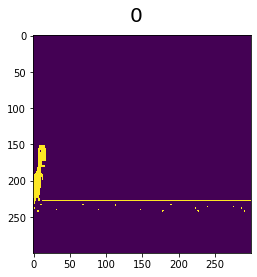

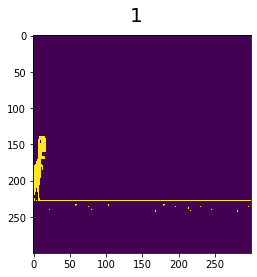

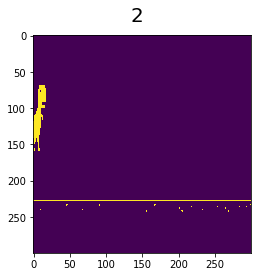

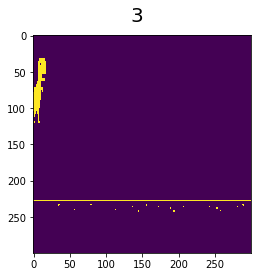

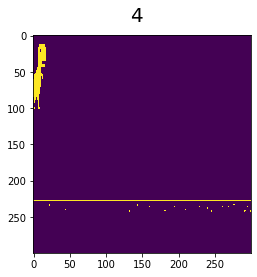

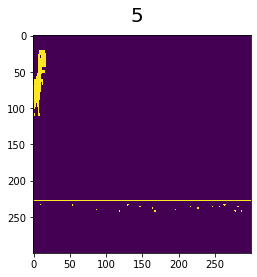

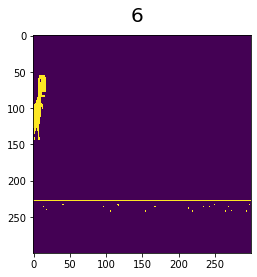

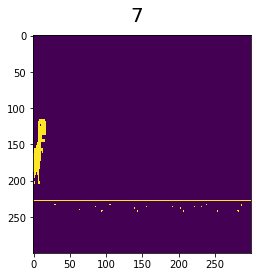

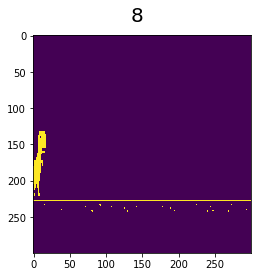

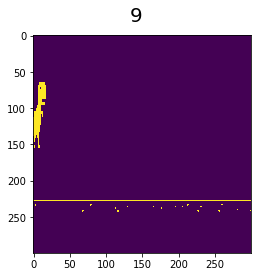

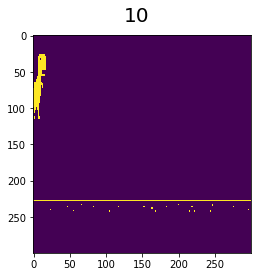

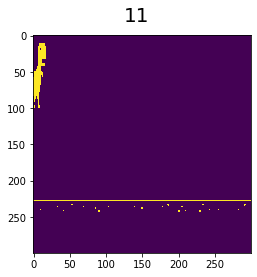

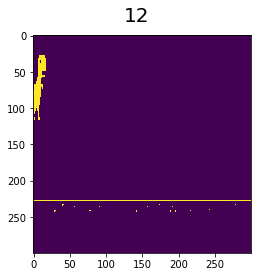

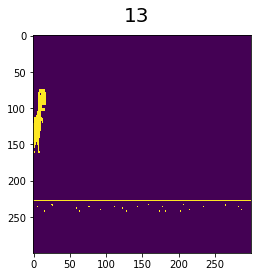

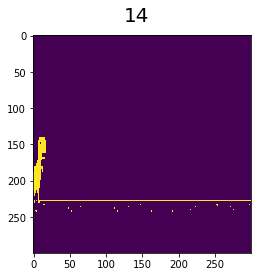

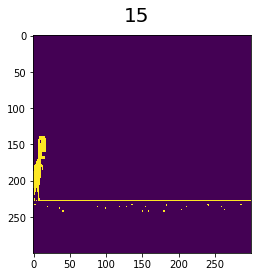

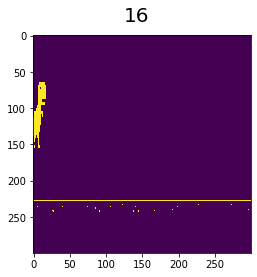

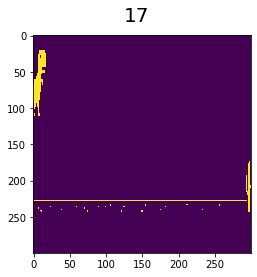

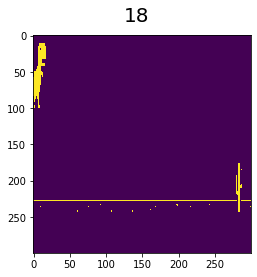

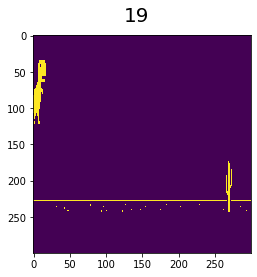

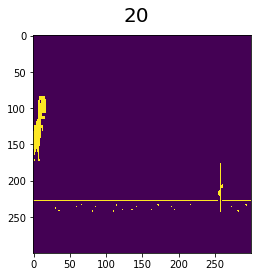

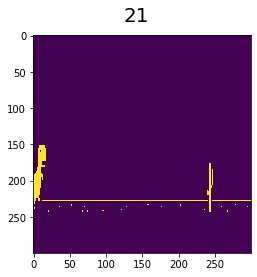

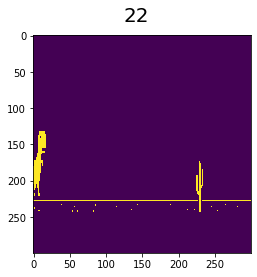

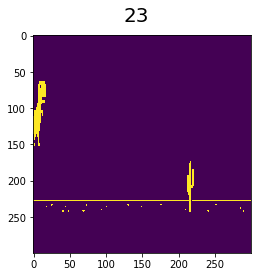

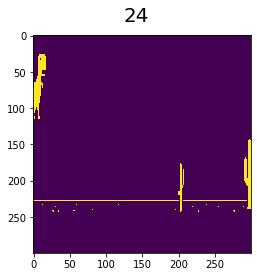

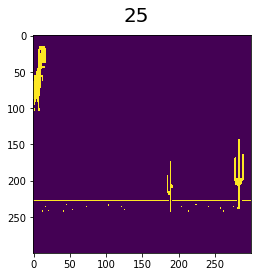

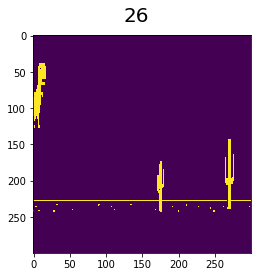

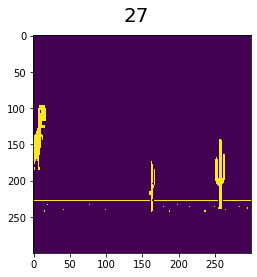

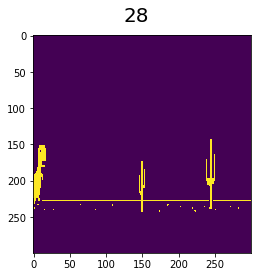

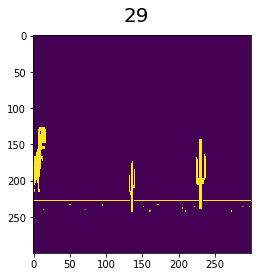

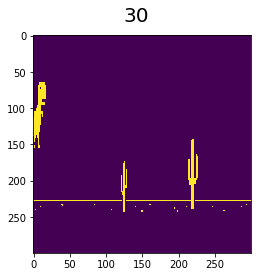

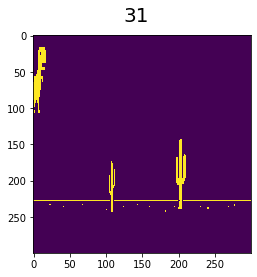

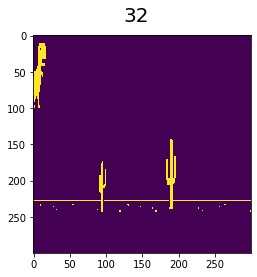

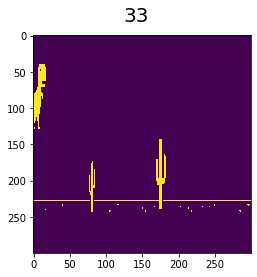

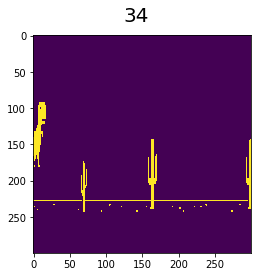

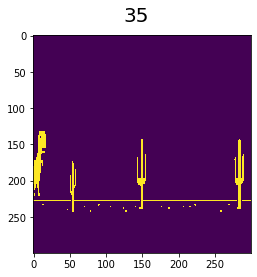

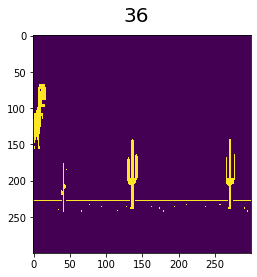

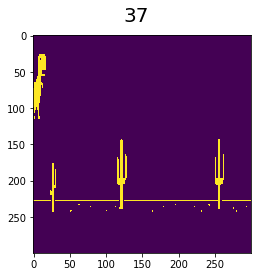

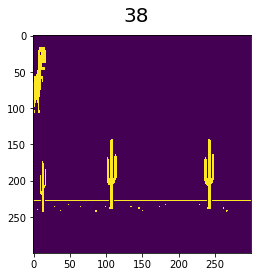

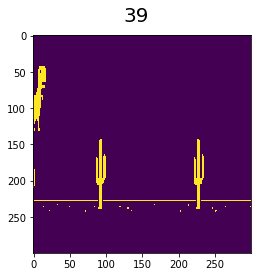

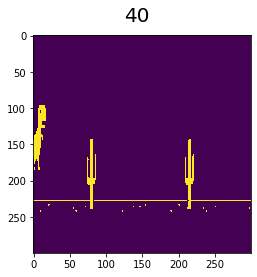

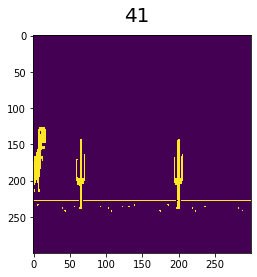

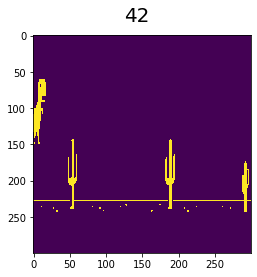

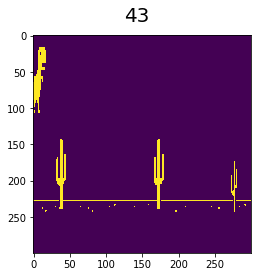

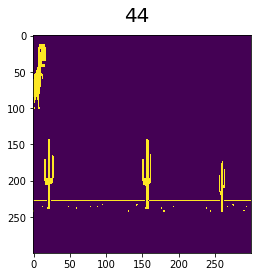

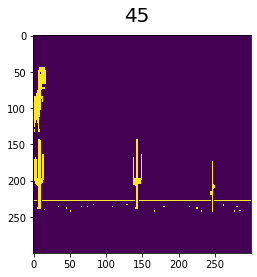

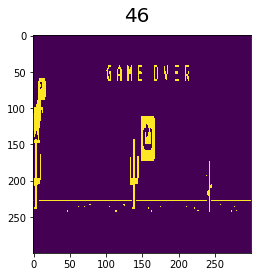

In [9]:
def train_player():
    itr = 0
    continue_loop = True
    model = build_model()
    time.sleep(5)
    
    prev_area = None
    restart()
    train_x = []
    train_y = []
    action_list = []
    num = 0
    while continue_loop:
        time1 = time.time()
        input_area, full_image = get_state_image()
        # display_image(input_area, num)
        input_area = input_area.reshape(input_area.shape[0], input_area.shape[1], 1)
        input_area_conv = input_area.reshape(1, input_area.shape[0], input_area.shape[1], input_area.shape[2])
        t2 = time.time()
        print_time('dtctn tm:', t2 - time1)
        if prev_area is not None and num>5 and np.array_equal(full_image, prev_area):
            itr = itr + 1
            if itr%5 == 0:
                clear_output()
            print_data('train_x.shape',np.asarray(train_x).shape)
            if num>15:
                pred_output = model.predict(np.asarray(train_x))
                print_data('pred_output:',pred_output)
                print_data(train_y)
                train_data(train_x, train_y, action_list)
                train_x = []
                train_y = []    
                action_list = []
                continue_loop = False
                # print_data('length of training set', len(train_x))
                # print_data('train_x_shape before training', np.asarray(train_x).shape)
                # print_data('train_y_shape before t raining', np.asarray(train_y).shape)
            t3 = time.time()
            prev_area = None
            # print_time('Training time', t3-t2)
            time.sleep(5)
            num = 0
            restart()
            if itr == 100:
                continue_loop = False
        else:
            t3 = time.time()
            print_data('input_area_conv shape:', input_area_conv.shape)
            prediction_output = model.predict(input_area_conv)
            action = np.argmax(prediction_output[0])
            action_list.append(action)
            print_data('Prdctn output', num, ': ', prediction_output)
            t4 = time.time()
            # print_time('Prdctn Time:' , t4 - time1)
            t = 0.15-(time.time()-t3)
            # print_time(t)
            time.sleep(t)
            check_val_and_act(action)
                
            num = num + 1
            input_area = input_area.reshape(input_area.shape[0], input_area.shape[1], 1)
            #np.append(train_x, input_area, axis=3)
            train_x.append(input_area)
            print_data('train_x_shape', np.asarray(train_x).shape)
            # train_y_temp = model.predict(np.asarray(train_x))
            # print_data('Prediction Output', output)
            train_y.append(prediction_output[0])
            print_data('train_y_shape', np.asarray(train_y).shape)
            
        prev_area = full_image
        time2 = time.time()
        # print_time('Loop time:', time2 - time1)

train_player()